In [2]:
import matplotlib.pyplot as plt

def show_images(*images):
    n = ncols = len(images)
    nrows = (n + ncols - 1) // ncols  # Liczba wierszy

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 4))

    # Spłaszczenie tablicy axes, aby łatwiej było przypisać obrazy do osi
    axes = axes.flatten()

    for i in range(n):
        
        axes[i].imshow(images[i])
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    # Ukrycie nieużywanych osi
    for i in range(n, len(axes)):
        axes[i].axis('off')

    plt.show()


In [4]:
import numpy as np
import lpips


def SNE(X1: np.ndarray, X2: np.ndarray) -> float:
    return np.sum((X1 - X2) ** 2)


def MSE(X1: np.ndarray, X2: np.ndarray) -> float:
    return np.mean((X1 - X2) ** 2)


def PSNR(X1: np.ndarray, X2: np.ndarray, max: int = 255) -> float:
    return 10 * np.log10(max**2 / MSE(X1, X2))


def SSIM(X1: np.ndarray, X2: np.ndarray, C1=0.01**2, C2=0.03**2) -> float:
    mu1 = np.mean(X1)
    mu2 = np.mean(X2)

    sigma1_sq = np.var(X1)
    sigma2_sq = np.var(X2)

    sigma12 = np.mean((X1 - mu1) * (X2 - mu2))

    numerator = (2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)
    denominator = (mu1**2 + mu2**2 + C1) * (sigma1_sq + sigma2_sq + C2)

    return numerator / denominator


def LPIPS(X1: np.ndarray, X2: np.ndarray, net="alex") -> float:
    loss_fn = lpips.LPIPS(net=net)
    return loss_fn(X1, X2).item()


In [4]:
import cv2
import numpy as np

def resize(X: np.ndarray, size: tuple[int, int]) -> np.ndarray:
    return cv2.resize(X, size, interpolation=cv2.INTER_CUBIC)

In [1]:
import os

def resize_images(input_folder: str, output_folder: str, size: tuple[int, int]):
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        img = cv2.imread(input_path)
        resized_img = resize(img, size)
        cv2.imwrite(output_path, resized_img)

In [5]:
INPUT_FOLDER = "DIV2K_train_HR"
OUTPUT_FOLDER_256 = "images_256"
OUTPUT_FOLDER_64 = "images_64"

resize_images(INPUT_FOLDER, OUTPUT_FOLDER_256, (256, 256))
resize_images(OUTPUT_FOLDER_256, OUTPUT_FOLDER_64, (64, 64))

In [3]:
import torch.nn as nn


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self._layers = nn.Sequential(
            # Pierwsza warstwa: 256x256 -> 128x128
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            
            # Druga warstwa: 128x128 -> 64x64
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            # Warstwa końcowa: dostosowanie kanałów
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, padding=1),
            nn.Sigmoid()  # Wartości w zakresie [0,1] dla pikseli
        )

    def forward(self, x):
        return self._layers(x)


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self._layers = nn.Sequential(
            # Pierwsza warstwa: 64x64 -> 128x128
            nn.ConvTranspose2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            # Druga warstwa: 128x128 -> 256x256
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            
            # Warstwa końcowa: dostosowanie kanałów
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, padding=1),
            nn.Sigmoid()  # Wartości w zakresie [0,1] dla pikseli
        )

    def forward(self, x):
        return self._layers(x)
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder(self.encoder(x))


In [4]:
import torch
from torch.utils.data import Dataset


class ImageDataset(Dataset):
    def __init__(self, folder: str):
        self.folder = folder
        self.image_files = [
            f
            for f in sorted(os.listdir(folder))
            if os.path.isfile(os.path.join(folder, f))
            and f.lower().endswith((".png", ".jpg", ".jpeg", ".bmp"))
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.folder, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0  # Normalizacja do zakresu [0,1]

        img = torch.from_numpy(
            img.transpose(2, 0, 1)
        ).float()  # Zmiana na float zamiast domyślnego double
        return img

In [9]:
import torch
import torch.optim as optim

def train_autoencoder(
    model,
    train_loader,
    num_epochs,
    learning_rate=0.001,
    device="cuda" if torch.cuda.is_available() else "cpu",
):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, images in enumerate(train_loader):
            # Zakładamy, że obrazy są już w odpowiednim formacie
            images = images.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (
                batch_idx % 10 == 9
            ):  # Zmniejszam częstotliwość wyświetlania dla czytelności
                print(
                    f"Epoka [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], "
                    f"Loss: {running_loss / 10:.4f}"
                )
                running_loss = 0.0

        epoch_loss = running_loss / len(train_loader)
        print(
            f"Epoka [{epoch + 1}/{num_epochs}] zakończona, Średnia strata: {epoch_loss:.4f}"
        )

    return model


In [7]:
from torch.utils.data import DataLoader
import os
import cv2
batch_size = 16
num_epochs = 10
learning_rate = 0.001
data_folder = "images_256"  # Zmień na swoją ścieżkę

# Przygotowanie danych
train_dataset = ImageDataset(folder=data_folder)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Inicjalizacja modelu
autoencoder = Autoencoder()

# Sprawdzenie przykładowego obrazu
sample_img = train_dataset[0]
print(f"Rozmiar przykładowego obrazu: {sample_img.shape}")
# Trening
# trained_model = train_autoencoder(
#     model=autoencoder,
#     train_loader=train_loader,
#     num_epochs=num_epochs,
#     learning_rate=learning_rate
# )

# # Zapis modelu
# torch.save(trained_model.state_dict(), 'autoencoder.pth')
# print("Model zapisany jako 'autoencoder.pth'")

Rozmiar przykładowego obrazu: torch.Size([3, 256, 256])


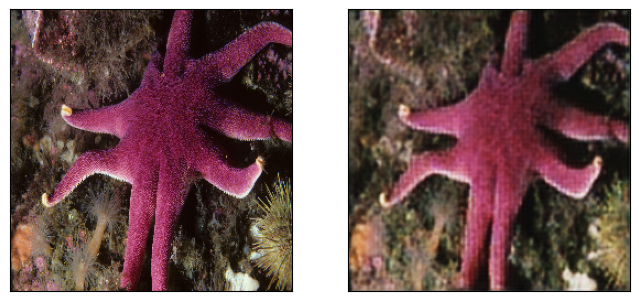

In [17]:
model = Autoencoder()
model.load_state_dict(torch.load('autoencoder.pth'))
model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

with torch.no_grad():
    test_img = train_dataset[0].unsqueeze(0).to(device)
    reconstructed = model(test_img)
    reconstructed_np = reconstructed.squeeze().cpu().numpy().transpose(1, 2, 0)
    show_images(test_img.squeeze(0).permute(1, 2, 0).numpy(), reconstructed_np)

In [8]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def test_decoder(
    decoder,
    dataset,
    num_images=10,
    device="cuda" if torch.cuda.is_available() else "cpu",
    output_folder="output_images",
):
    decoder = decoder.to(device)
    decoder.eval()

    # Pobieramy 10 pierwszych obrazów
    for i in range(min(num_images, len(dataset))):
        ground_truth = load_image(f"images_256/{i+1:04d}.png")
        input_img = dataset[i].unsqueeze(0).to(device)  # Dodajemy wymiar batch

        with torch.no_grad():
            output_img = decoder(input_img)

        # Konwersja do formatu OpenCV (H, W, C)
        input_np = input_img.squeeze().cpu().numpy().transpose(1, 2, 0) * 255
        output_np = output_img.squeeze().cpu().numpy().transpose(1, 2, 0) * 255
        output_rgb = output_np.astype(np.uint8)
        # Zapis wyników
        show_images(input_np.astype(np.uint8), output_rgb, ground_truth)
        # cv2.imwrite(f"{output_folder}/input_64x64_{i}.png", input_np.astype(np.uint8))
        # cv2.imwrite(f"{output_folder}/output_256x256_{i}.png", output_np.astype(np.uint8))

        # print(
        #     f"Zapisano: input_64x64_{i}.png (wejście) i output_256x256_{i}.png (wyjście)"
        # )

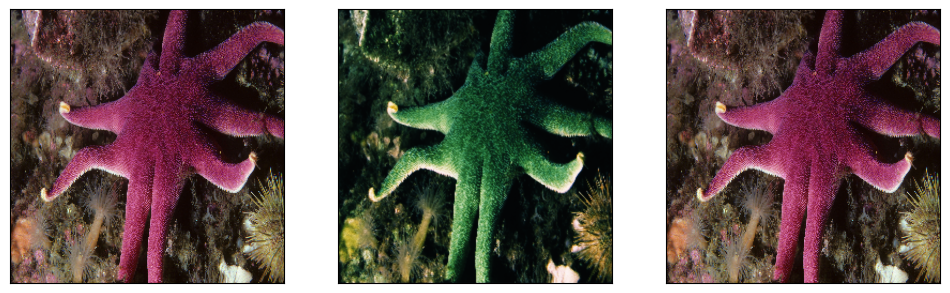

In [14]:
import torch
import numpy as np
decoder = Decoder()
autoencoder_state_dict = torch.load('autoencoder.pth')
decoder_state_dict = {k.replace('decoder.', ''): v for k, v in autoencoder_state_dict.items() if k.startswith('decoder.')}

decoder.load_state_dict(decoder_state_dict)

dataset = ImageDataset(folder="images_256")
test_decoder(decoder, dataset, num_images=1, output_folder="output_images")

(256, 256, 3) (64, 64, 3)


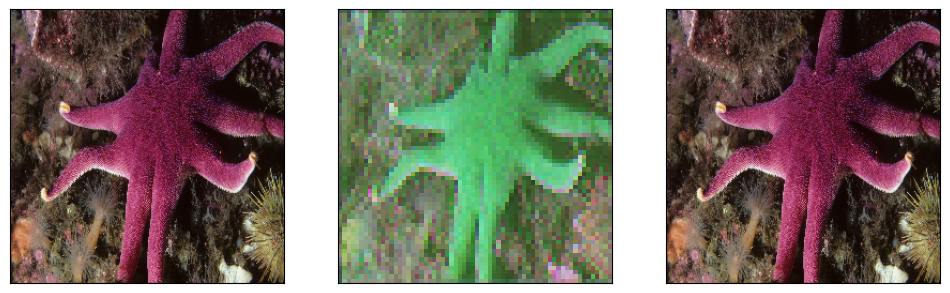

In [ ]:
encoder = Encoder()

encoder_state_dict = {k.replace('encoder.', ''): v for k, v in autoencoder_state_dict.items() if k.startswith('encoder.')}
encoder.load_state_dict(encoder_state_dict)

def test_encoder(
    encoder,
    dataset,
    num_images=10,
    device="cuda" if torch.cuda.is_available() else "cpu",
    output_folder="output_images",
):
    encoder = encoder.to(device)
    encoder.eval()

    # Pobieramy 10 pierwszych obrazów
    for i in range(min(num_images, len(dataset))):
        ground_truth = load_image(f"images_256/{i+1:04d}.png")
        input_img = dataset[i].unsqueeze(0).to(device)  # Dodajemy wymiar batch

        with torch.no_grad():
            output_img = encoder(input_img)

        # Konwersja do formatu OpenCV (H, W, C)
        input_np = input_img.squeeze().cpu().numpy().transpose(1, 2, 0) * 255
        output_np = output_img.squeeze().cpu().numpy().transpose(1, 2, 0) * 255
        output_rgb = output_np.astype(np.uint8)
        # Zapis wyników
        show_images(input_np.astype(np.uint8), output_rgb, ground_truth)
        # cv2.imwrite(f"{output_folder}/input_64x64_{i}.png", input_np.astype(np.uint8))
        # cv2.imwrite(f"{output_folder}/output_256x256_{i}.png", output_np.astype(np.uint8))

        # print(
        #     f"Zapisano: input_64x64_{i}.png (wejście) i output_256x256_{i}.png (wyjście)"
        # )

test_encoder(encoder, dataset, num_images=1, output_folder="output_images")